In [ ]:
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

import tensorflow as tf
from tensorflow import keras

keras.utils.set_random_seed(42)

In [ ]:
# install transformer package
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 3.6 MB/s 
     |████████████████████████████████| 7.6 MB 31.3 MB/s 
     |████████████████████████████████| 182 kB 57.9 MB/s 


In [ ]:
from transformers import BertTokenizer

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-6093d442-da2d-ea66-4702-11925f1d255a)


In [ ]:
df = pd.read_csv('https://www.dropbox.com/s/bftxg089s8bx86f/Financial%20Sentiment%20Data.csv?dl=1')

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(df['Sentence'], df['Sentiment'], test_size=0.25, random_state=42, stratify=df['Sentiment'])

In [ ]:
n_neu = train_y.value_counts()['neutral']
n_pos = train_y.value_counts()['positive']
n_neg = train_y.value_counts()['negative']

train_y.value_counts()

neutral     2347
positive    1389
negative     645
Name: Sentiment, dtype: int64

In [ ]:
# balance data -> upsample minority class
train = pd.concat([train_X, train_y], axis=1)
train_pos = pd.concat([train[train.Sentiment=='positive'], 
                      train[train.Sentiment=='positive'].sample(n=(n_neu-n_pos), replace=True, random_state=42)])
train_neg = pd.concat([train[train.Sentiment=='negative'],
                       train[train.Sentiment=='negative'].sample(n=(n_neu-n_neg), replace=True, random_state=42)])
train_balanced = pd.concat([train_pos, train_neg, train[train.Sentiment=='neutral']])
train_X, train_y = train_balanced['Sentence'], train_balanced['Sentiment']

train_y.value_counts()

positive    2347
negative    2347
neutral     2347
Name: Sentiment, dtype: int64

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
max_query_length = 100

In [ ]:
# tokenize both the training set and the test set
source_train = tokenizer(train_X.values.tolist(), max_length=max_query_length, return_tensors='tf', truncation=True, padding='max_length')
source_test = tokenizer(test_X.values.tolist(), max_length=max_query_length, return_tensors='tf', truncation=True, padding='max_length')

In [ ]:
# tokenize labels
text_vectorization_label = keras.layers.TextVectorization()
text_vectorization_label.adapt(train_y.astype(str))
num_labels = text_vectorization_label.vocabulary_size()

label_train = text_vectorization_label(train_y.astype(str))
label_test = text_vectorization_label(test_y.astype(str))

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
fine_tuned = keras.models.load_model('/content/drive/Shareddrives/580 shared drive/final_project/fine_tuned_bert_1')

In [ ]:
# Get input
new_input = fine_tuned.input
# Find the layer to connect
hidden_layer = fine_tuned.layers[-2].output['pooler_output']
# Connect a new layer on it
x = keras.layers.Dense(256, activation='relu')(hidden_layer)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
new_output = keras.layers.Dense(num_labels, activation="softmax")(x)
# Build a new model
model = keras.Model(inputs=new_input, outputs=new_output)

for layer in model.layers:#[:-7]:
  layer.trainable = True

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 bert (Custom>TFBertMainLayer)  {'last_hidden_state  108310272   ['input_ids[0][0]',              
                                ': (None, 100, 768)               'token_type_ids[0][0]',     

In [ ]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["sparse_categorical_accuracy"])

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.00005)

In [ ]:
BATCH_SIZE = 64
epochs = 4

# Fit
history = model.fit([source_train['input_ids'], source_train['token_type_ids'], source_train['attention_mask']], label_train,
                    batch_size=BATCH_SIZE,
                    validation_data=([source_test['input_ids'], source_test['token_type_ids'], source_test['attention_mask']], label_test),
                    epochs=epochs)

Epoch 1/4
111/111 [==============================] - 156s 1s/step - loss: 1.2864 - sparse_categorical_accuracy: 0.4802 - val_loss: 0.8613 - val_sparse_categorical_accuracy: 0.7091
Epoch 2/4
111/111 [==============================] - 148s 1s/step - loss: 0.7534 - sparse_categorical_accuracy: 0.7333 - val_loss: 0.9013 - val_sparse_categorical_accuracy: 0.7283
Epoch 3/4
111/111 [==============================] - 151s 1s/step - loss: 0.5085 - sparse_categorical_accuracy: 0.8344 - val_loss: 0.7003 - val_sparse_categorical_accuracy: 0.7687
Epoch 4/4
111/111 [==============================] - 153s 1s/step - loss: 0.3996 - sparse_categorical_accuracy: 0.8718 - val_loss: 0.9103 - val_sparse_categorical_accuracy: 0.7584


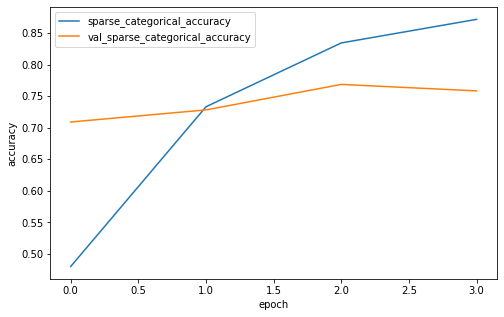

In [ ]:
pd.DataFrame(history.history)[['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot(figsize=(8,5))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

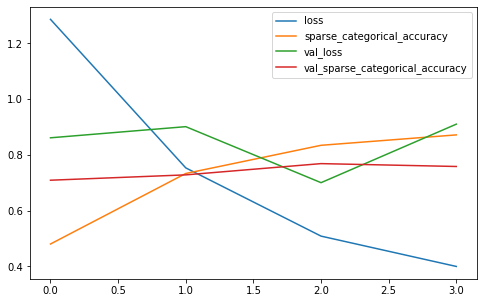

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

46/46 [==============================] - 11s 224ms/step


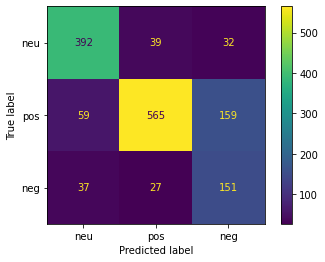

In [ ]:
pred = np.argmax(model.predict(x=[source_test['input_ids'], source_test['token_type_ids'], source_test['attention_mask']]),axis=1)

disp = ConfusionMatrixDisplay(confusion_matrix(tf.squeeze(label_test), pred, labels=[2,3,4]),
                       display_labels=['neu','pos','neg'])
disp.plot()
plt.show()

In [ ]:
f1_score(tf.squeeze(label_test), pred, average='weighted')

0.7693370811600887